In [1]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import random
import pandas as pd
import logging
from tqdm import tqdm
import time

In [2]:
title = "Software Developer"  
location = "New York"  
NUMBER_OF_JOBS_TO_FETCH = 600
SAVE_DATA = True

In [3]:
import os
os.makedirs('./results', exist_ok=True) # will dump results here

In [4]:
from collections import defaultdict
programming_languages = pd.read_csv('./skills.csv')['skills'].to_list()
programming_languages = set(programming_languages)

users_of_languages = defaultdict(int)
for l in programming_languages:
    users_of_languages[l] = 0

In [5]:
job_list = []

In [6]:
for start in tqdm(range(0, NUMBER_OF_JOBS_TO_FETCH, 25)):
    list_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={title}&location={location}&distance=25&f_TPR=&f_WT=1&start={start}"

    response = requests.get(list_url)

    list_data = response.text
    list_soup = BeautifulSoup(list_data, "html.parser")
    page_jobs = list_soup.find_all("li")
        
    id_list = []

    for job in page_jobs:
        base_card_div = job.find("div", {"class": "base-card"})
        job_id = base_card_div.get("data-entity-urn").split(":")[3]
        id_list.append(job_id)
    
    for job_id in id_list:
        job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
        
        job_response = requests.get(job_url)
        if job_response.status_code != 200:
            logging.warning(f"Failed to retrieve job posting {job_id}: Status code {job_response.status_code}")
            continue
        job_soup = BeautifulSoup(job_response.text, "html.parser")
        
        job_post = {}
        
        try:
            job_post["job_title"] = job_soup.find("h2", {"class":"top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
        except:
            job_post["job_title"] = None
            
        try:
            job_post["company_name"] = job_soup.find("a", {"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
        except:
            job_post["company_name"] = None

        try: 
            job_post["location"] = job_soup.find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip().split(",")[0].strip()
        except:
            job_post["location"] = None
            
        try:
            job_post["time_posted"] = job_soup.find("span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
        except:
            job_post["time_posted"] = None
            
        try:
            job_post["num_applicants"] = job_soup.find("span", {"class": "num-applicants__caption topcard__flavor--metadata topcard__flavor--bullet"}).text.strip().replace(" applicants", "")
        except:
            job_post["num_applicants"] = 0 

        for lang in programming_languages:
            if f"{lang.lower()}" in job_soup.find("div", {"class": "show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden"}).text.lower():  
                users_of_languages[lang] += 1 
        job_list.append(job_post)
        time.sleep(random.uniform(1, 3)) # Sleep between requests to avoid rate limiting 

100%|██████████| 24/24 [10:03<00:00, 25.13s/it]


## Job postings 

In [7]:
jobs_df = pd.DataFrame(job_list)
print(f"Total job postings collected: {len(jobs_df)}")
jobs_df.head(15)

Total job postings collected: 240


,job_title,company_name,location,time_posted,num_applicants
0,Software Engineer 1,Intuit,New York,2 weeks ago,0
1,Software Engineer (All Levels),Blossom,New York,4 weeks ago,0
2,Full Stack Engineer (L5) - Consumer Data Systems,Netflix,New York,6 days ago,0
3,Full Stack Engineer (New Grad),OffDeal,New York,4 weeks ago,0
4,"Data Engineer, Analytics (University Grad)",Meta,New York,2 weeks ago,0
5,Software Engineer,Hype,New York,8 months ago,0
6,"Software Engineer I, Entry-Level (Graduation D...",DoorDash,New York,1 week ago,0
7,Software Developer,Point72,New York,2 weeks ago,0
8,Software Engineer - Internship,SeatGeek,New York,5 days ago,0
9,"Backend Software Engineer, CloudKitchens - New...",CloudKitchens,New York,5 days ago,0


In [8]:
if SAVE_DATA:
    jobs_df.to_csv(f'./results/jobs_{title}_{location}.csv', index=False)

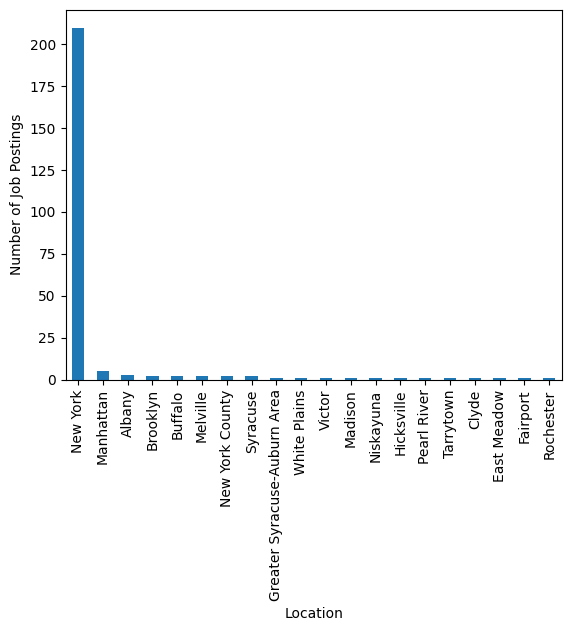

In [9]:
jobs_df["location"].value_counts().plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Number of Job Postings')
plt.savefig(f'./results/job_locations_{title}_{location}.png')
plt.show()

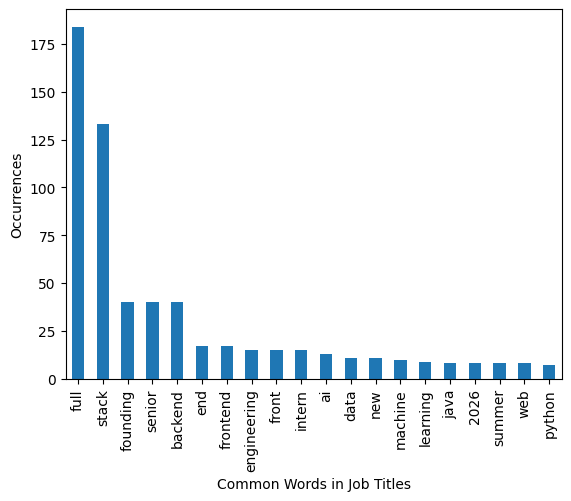

In [15]:
jobs_df['job_title_cleaned'] = jobs_df['job_title'].str.replace(r'[\/\-\,\(\)\.]', ' ', regex=True)
all_words = ' '.join(jobs_df['job_title_cleaned'].dropna().tolist()).lower().split()
word_counts = pd.Series(all_words).value_counts()
common_words = word_counts[word_counts > 2]
common_words.plot(kind='bar')
common_words = common_words.drop(errors="ignore", labels=['developer', "utvecklare", "mjukvaruutvecklare", 'engineer', 'software', 'and', 'lead', "iii" 'ii', 'i', 'working', 'from', 'home', 'm/f/d', 'h/f', 'the', 'a', 'to', 'in', 'of', 'for', 'with', 'on', 'at', 'as', 'is', 'by', 'an', "inom", "för", "all", "+", "-"])
common_words = common_words.head(20)
common_words.plot(kind='bar')
plt.xlabel('Common Words in Job Titles')
plt.ylabel('Occurrences')
plt.savefig(f'./results/common_words_job_titles_{title}_{location}.png')
plt.show()

## Skills usage in job postings 

In [11]:
lang_usage = pd.DataFrame.from_dict(users_of_languages, orient='index', columns=['Number of Job Postings']).reset_index().rename(columns={'index': 'Programming Language'})
lang_usage.drop(lang_usage[lang_usage['Number of Job Postings'] == 0].index, inplace=True)
lang_usage = lang_usage.sort_values(by='Number of Job Postings', ascending=False)
lang_usage = lang_usage.reset_index(drop=True)
lang_usage.head(20)

,Programming Language,Number of Job Postings
0,Python,119
1,Java,100
2,React,95
3,AWS,86
4,TypeScript,76
5,Git,69
6,SQL,69
7,Rust,61
8,JavaScript,53
9,Ada,43


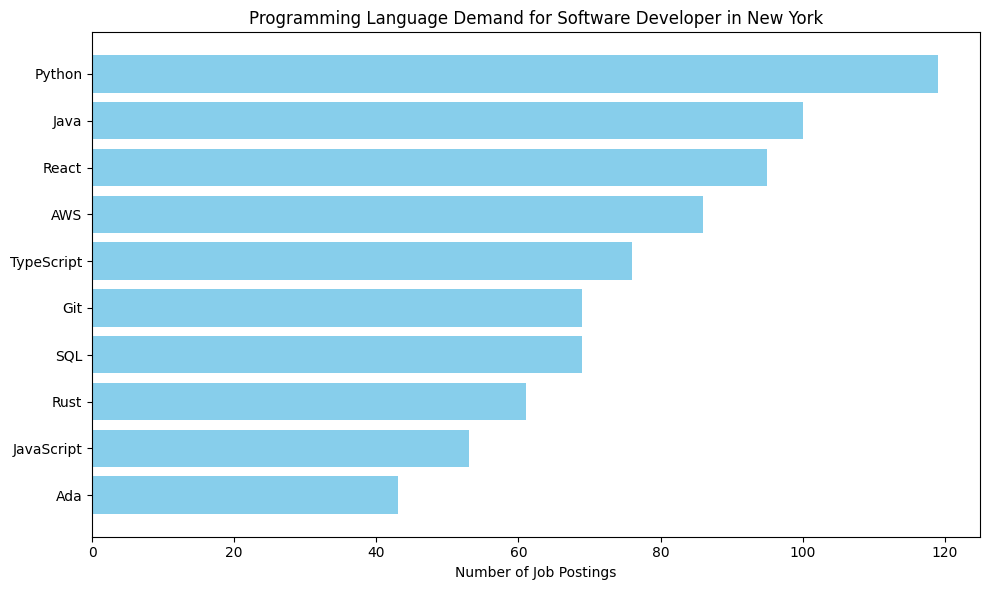

In [12]:
plt.figure(figsize=(10, 6))
plt.barh(lang_usage['Programming Language'].iloc[:10], lang_usage['Number of Job Postings'].iloc[:10], color='skyblue')
plt.xlabel('Number of Job Postings')
plt.title(f'Programming Language Demand for {title} in {location}')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig(f'./results/language_demand_{title}_{location}.png')
plt.show()

In [13]:
if SAVE_DATA:
    lang_usage.to_csv(f'./results/skills_{title}_{location}.csv', index=False)